# Process Your Solar Eclipse Photos with SunPy!

On April 8th, 2024, [a total solar eclipse will pass over North America](https://science.nasa.gov/eclipses/).
A total solar eclipse happens when the Moon passes between the Sun and Earth, completely blocking the face of the Sun.
Only during totality, when the bright disk is completely obscured, is it possible to see with the naked eye the solar corona, the outermost layer of the Sun's atmosphere.
The total solar eclipse will give millions across North America the chance to see and photograph the solar corona.

In this blog post, we will show how you can use SunPy to process your photos of the eclipse.
To do this, we will use an image from the 2017 solar eclipse that also passed over North America, the so-called "Great American Eclipse".
We will walk through processing this image with SunPy as well as other Python libraries, so that you can generate a coordinate system for your image.
As we will show, this allows you to combine your eclipse images with solar observations such as those from NASA's *Solar Dynamics Observatory*.

In [1]:
from pathlib import Path

import astropy.units as u
import exifread
import matplotlib.image
import matplotlib.pyplot as plt
import numpy as np
import sunpy.coordinates
import sunpy.coordinates.sun
from astropy.constants import R_earth
from astropy.coordinates import CartesianRepresentation, EarthLocation, SkyCoord

# We have defined a few helper functions in this `eclipse_helpers.py` file.
from eclipse_helpers import SOLAR_ECLIPSE_IMAGE, get_camera_metadata
from matplotlib.patches import Circle
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.transform import hough_circle, hough_circle_peaks
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import parse_time

## Read in Your Eclipse Photo

The first step is to read in our image.
As mentioned above, we will be using an image taken during the 2017 eclipse taken with a consumer-grade camera.
When reading in our image data, we'll invert the y-axis and convert it to a grayscale image.

In [2]:
im_rgb = np.flipud(matplotlib.image.imread(SOLAR_ECLIPSE_IMAGE))
im = rgb2gray(im_rgb)

/Users/laurahayes/miniforge3/envs/sunpy_docs/lib/python3.13/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/laurahayes/miniforge3/envs/sunpy_docs/lib/python3.13/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/laurahayes/miniforge3/envs/sunpy_docs/lib/python3.13/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


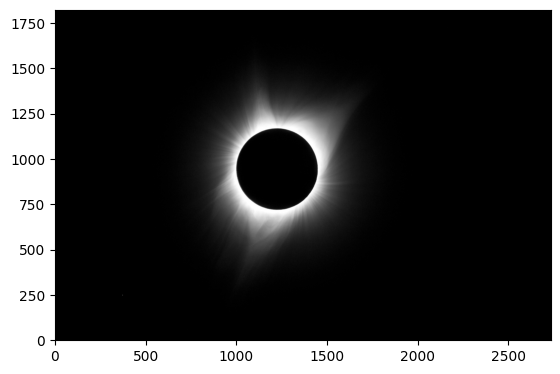

In [3]:
plt.imshow(im, origin="lower", cmap="gray")
plt.show()

In order to be able to align our image with solar images from NASA, we will also need some additional metadata from our image.
The two most important things we need to know are:

1. the GPS coordinates of where the photo was taken and
2. the time the image was taken

We can pull this metadata from the file and then use an additional function we wrote to process this metadata into a Python dictionary.

In [4]:
with Path(SOLAR_ECLIPSE_IMAGE).open("rb") as f:
    tags = exifread.process_file(f)

In [5]:
camera_metadata = get_camera_metadata(tags)

As it turns out, the time on the camera used to take this eclipse photo was wrong, we have to manually correct it.

In [6]:
camera_metadata["time"] = parse_time("2017-08-21 17:27:13")

## Find the Moon

Now that we've loaded our image and accompanying metadata, the next step is to locate the edge of the Moon in our image.
This allows us to find the center of the Moon, which is needed when aligning our data, as well as allowing us to determine the scale of the Moon in the image.
In order to do this we are going to use several different image manipulation techniques.


We start with applying a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_filter) to help segment the lunar disk from the corona and mask all parts of the image above a given threshold.

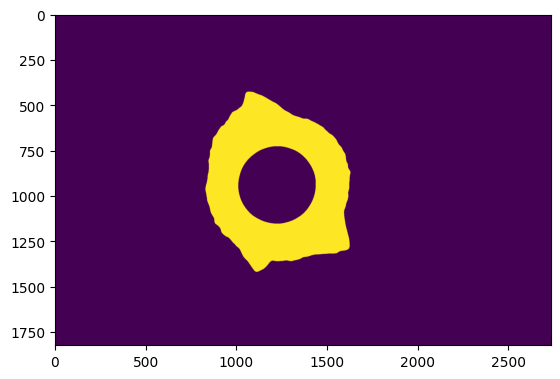

In [7]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)
plt.show()

We then label those masked regions and select only the parts of the image that correspond to the bright, diffuse corona.

In [8]:
label_im, nb_labels = ndimage.label(mask)
slice_y, slice_x = ndimage.find_objects(label_im == 1)[0]
roi = blur_im[slice_y, slice_x]

The next step is to detect the inner edge of the bright corona.
To do this, we apply a [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator) in both the x and y directions, and then calculate a single image from the two directions.

In [9]:
sx = ndimage.sobel(roi, axis=1, mode="constant")
sy = ndimage.sobel(roi, axis=0, mode="constant")
sob = np.hypot(sx, sy)

Finally, we use scikit-image to apply the [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform) to identify circles in the image.
We then use this to extract the size in pixels of the lunar disk and its center.

In [10]:
hough_radii = np.arange(np.floor(np.mean(sob.shape) / 4), np.ceil(np.mean(sob.shape) / 2), 10)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent circle
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

As shown below, we now have a list of pixel coordinates corresponding to the solar limb in our image.
The first frame is the cropped original image.
The middle frame is the Sobel filtered image used to apply the Hough transform.
The right frame is the fitted circle on the original image.

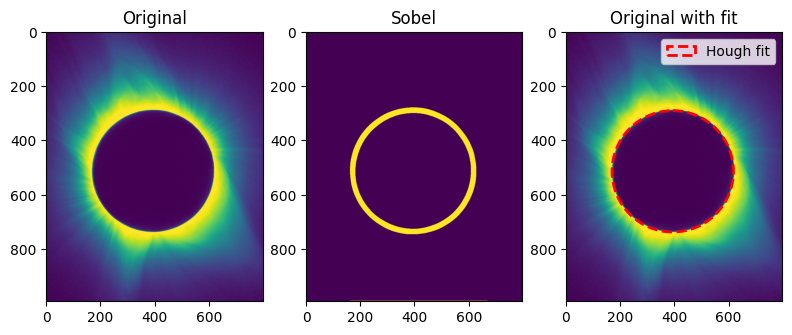

In [11]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9.5, 6))
ax[0].imshow(im[slice_y, slice_x])
ax[0].set_title("Original")
ax[1].imshow(sob > (sob.mean() * 5))
ax[1].set_title("Sobel")
circ = Circle(
    [cx, cy], radius=radii, facecolor="none", edgecolor="red", linewidth=2, linestyle="dashed", label="Hough fit"
)
ax[2].imshow(im[slice_y, slice_x])
ax[2].add_patch(circ)
ax[2].set_title("Original with fit")
plt.legend()
plt.show()

Lastly, let's add units to our circle that we fit the lunar limb.

In [12]:
im_cx = (cx[0] + slice_x.start) * u.pix
im_cy = (cy[0] + slice_y.start) * u.pix
im_radius = radii[0] * u.pix

## Make a SunPy `Map`

At this point, we have our image data, it's metadata and we've located the Moon.
Now we are ready to load our eclipse photograph into a SunPy `Map`!
A `Map` allows us to carry around both the data and metadata of our image together and, importantly, makes it easy to combine solar observations from multiple observatories.

First, we define the observer location (i.e., where on Earth did we take our picture?) and the orientation of the Sun in the sky.
For the observer location, we can use the GPS coordinates from our image metadata.

In [13]:
loc = EarthLocation(lat=camera_metadata["gps"][0], lon=camera_metadata["gps"][1], height=camera_metadata["gps"][2])
observer = loc.get_itrs(camera_metadata["time"])

Second, we determine the [angular size](https://en.wikipedia.org/wiki/Angular_diameter) of the Moon using its radius and its distance from the observer.

In [14]:
moon = SkyCoord(sunpy.coordinates.get_body_heliographic_stonyhurst("moon", camera_metadata["time"], observer=observer))
R_moon = 0.2725076 * R_earth  # IAU mean radius
dist_moon = SkyCoord(observer).separation_3d(moon)
moon_obs = np.arcsin(R_moon / dist_moon).to("arcsec")
print(moon_obs)

2025-06-05 12:14:16 - sunpy - INFO: Apparent body location accounts for 1.23 seconds of light travel time


INFO: Apparent body location accounts for 1.23 seconds of light travel time [sunpy.coordinates.ephemeris]
975.9073137731282 arcsec


Combining this angular radius with the radius of the lunar disk in pixels gives us the angular size of the pixels in the image.
In the parlance of astronomical imaging, this is often referred to as the *plate scale*.

In [15]:
plate_scale = moon_obs / im_radius
print(plate_scale)

4.356729079344322 arcsec / pix


We also use the observer location to calculate the orientation of the Sun as seen from that location on Earth.
This gives us a rotation angle between our image coordinate system and the solar north pole.
If your camera is not perfectly horizontal then you may need to fudge this value slightly.

In [16]:
solar_rotation_angle = sunpy.coordinates.sun.orientation(loc, camera_metadata["time"])
print(solar_rotation_angle)

-54d19m44.13467961s


Finally we have all the information we need to build a sunpy `Map` for our eclipse image.

In [17]:
frame = sunpy.coordinates.Helioprojective(observer=observer, obstime=camera_metadata["time"])
moon_hpc = moon.transform_to(frame)

header = make_fitswcs_header(
    im,
    moon_hpc,
    reference_pixel=u.Quantity([im_cx, im_cy]),
    scale=u.Quantity([plate_scale, plate_scale]),
    rotation_angle=solar_rotation_angle,
    exposure=camera_metadata.get("exposure_time"),
    instrument=camera_metadata.get("camera_model"),
    observatory=camera_metadata.get("author"),
)

In [18]:
eclipse_map = sunpy.map.Map(im, header)

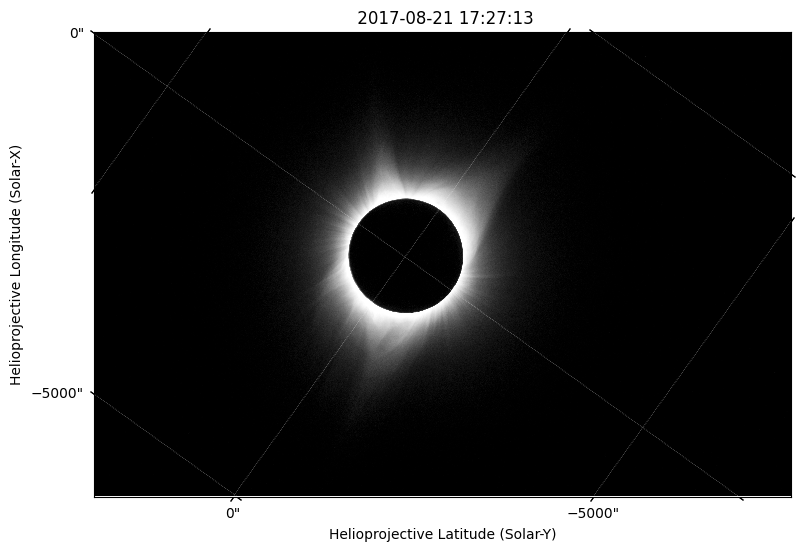

In [19]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(projection=eclipse_map)
eclipse_map.plot(axes=ax)
plt.show()

## Find a Star

Though we already have all of the metadata we need to make a SunPy `Map`, we can further improve the accuracy by 
locating a known star in the image and using that to determine the rotation angle.
In the case of the 2017 eclipse the very bright star (magnitude 1.4) [Regulus](https://en.wikipedia.org/wiki/Regulus) was close to the Sun and in the field of view of our photograph.
For the 2024 eclipse, no such bright star will be visible, which may make this method of aligning your image challenging.
The best candidate looks to be [Alpha Piscium](https://en.wikipedia.org/wiki/Alpha_Piscium) which is a binary system with a combined magnitude of 3.82, significantly dimmer than Regulus.
You can see the stars close to the Sun by using [Stellarium](https://stellarium-web.org/skysource/Sun?fov=1.1092&amp;date=2024-04-08T18:30:47Z&amp;lat=28.86&amp;lng=-100.53&amp;elev=0).

As Regulus is a well known star, we can create a coordinate object for it, including its distance.

In [20]:
regulus = SkyCoord(ra="10h08m22.311s", dec="11d58m01.95s", distance=79.3 * u.lightyear, frame="icrs")
print(regulus)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, lyr)
    (152.0929625, 11.96720833, 79.3)>


We can then plot the expected location of Regulus on our eclipse image.
We set the scaling such that it make Regulus more visible and zoom in on the relevant part of the field of view.
You can see that the expected location and the actual location are quite different.

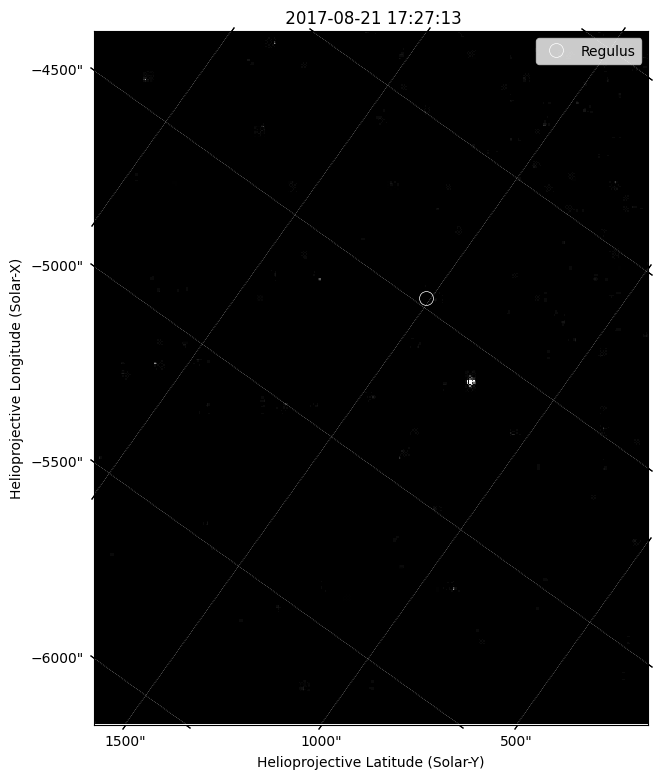

In [21]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(projection=eclipse_map)
eclipse_map.plot(axes=ax, clip_interval=(0, 90) * u.percent)
ax.plot_coord(
    regulus, "o", markeredgewidth=0.5, markeredgecolor="w", markerfacecolor="None", markersize=10, label="Regulus"
)
plt.legend()
plt.xlim(100, 500)
plt.ylim(0, 500)
plt.show()

Given this offset, we want to fix our image metadata such that the actual and expected locations of Regulus are line up.
We can calculate the expected distance from the center of the Sun to Regulus in pixels.

In [22]:
regulus_pixel = CartesianRepresentation(*eclipse_map.wcs.world_to_pixel(regulus), 0) * u.pix
sun_pixel = (
    CartesianRepresentation(*eclipse_map.wcs.world_to_pixel(SkyCoord(0 * u.arcsec, 0 * u.arcsec, frame=frame)), 0)
    * u.pix
)
regulus_r = (regulus_pixel - sun_pixel).norm()
print(regulus_r)

1084.0811009031981 pix


We then use this to find Regulus in our image, by filtering out all pixels which are closer to the Sun than this.

In [23]:
pix_x = np.arange(eclipse_map.dimensions[0].value) * u.pix - sun_pixel.x
pix_y = np.arange(eclipse_map.dimensions[1].value) * u.pix - sun_pixel.y
xx, yy = np.meshgrid(pix_x, pix_y)
r = np.sqrt(xx**2 + yy**2)

filter_r = regulus_r - (regulus_r / 5)

masked = im.copy()
masked[r < filter_r] = masked.min()

Having masked out most of the Sun and its corona, we now find the highest peak remaining, which should be Regulus.

In [24]:
regulus_y, regulus_x = peak_local_max(masked, min_distance=2, num_peaks=1)[0]
actual_regulus_pixel = CartesianRepresentation(regulus_x, regulus_y, 0) * u.pix

We can now compare the identified pixel coordinates of Regulus to the expected coordinates assuming the camera was exactly horizontal.

In [25]:
print(actual_regulus_pixel)
print(regulus_pixel)

(372., 247., 0.) pix
(339.45349652, 307.65804366, 0.) pix


Finally, we calculate the angular offset between our expected location and our identified location and then add this difference to correct our solar rotation angle.

In [26]:
vec_expected = regulus_pixel - sun_pixel
vec_actual = actual_regulus_pixel - sun_pixel
fudge_angle = -np.arccos(vec_expected.dot(vec_actual) / (vec_expected.norm() * vec_actual.norm()))
print(fudge_angle.to(u.deg))

-3.5738144694153595 deg


We then use this correction factor to build a new `Map` for our image with updated metadata.

In [27]:
header = make_fitswcs_header(
    im,
    moon_hpc,
    reference_pixel=u.Quantity([im_cx, im_cy]),
    scale=u.Quantity([plate_scale, plate_scale]),
    rotation_angle=solar_rotation_angle + fudge_angle,
    exposure=camera_metadata["exposure_time"],
    instrument=camera_metadata["camera_model"],
)

In [28]:
eclipse_map = sunpy.map.Map(im, header)

Plotting our image again, we now find that the identified location of Regulus and our image line up much better.

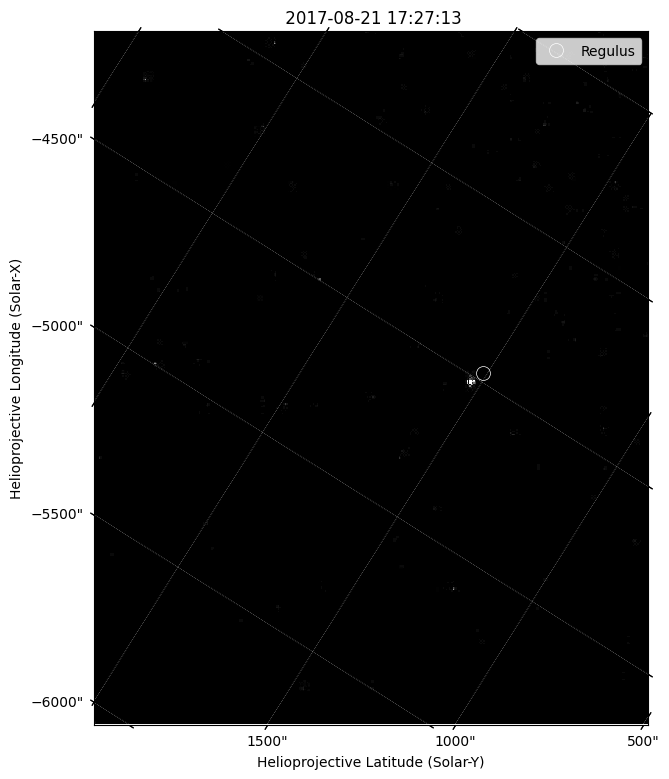

In [29]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(projection=eclipse_map)
eclipse_map.plot(axes=ax, clip_interval=(0, 90) * u.percent)
ax.plot_coord(
    regulus, "o", markeredgewidth=0.5, markeredgecolor="w", markerfacecolor="None", markersize=10, label="Regulus"
)
plt.legend()
plt.xlim(100, 500)
plt.ylim(0, 500)
plt.show()

## Combine your Image with NASA Data

As mentioned above, one of the main advantages of having data in a `Map` is that it is then easy to combine observations from multiple different sources.
Let's overlay an AIA image from the [SDO](https://en.wikipedia.org/wiki/Solar_Dynamics_Observatory) satellite.
We'll choose an image that shows extreme ultraviolet emission from the corona, revealing plasma that is around one million degrees.
Fortunately, all SDO data is publicly available and SunPy provides a convenient interface for searching for and downloading this data.

In [30]:
aia_result = Fido.search(
    a.Time("2017-08-21 17:27:00", "2017-08-21 17:45:00", eclipse_map.date),
    a.Instrument("AIA"),
    a.Wavelength(171 * u.Angstrom),
)
print(aia_result)

Results from 1 Provider:

1 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 67.789 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2017-08-21 17:27:09.000 2017-08-21 17:27:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844




In [32]:
aia_result[0, 0]

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,fileid
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64,str24
2017-08-21 17:27:09.000,2017-08-21 17:27:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:171:1282411667


In [33]:
files = Fido.fetch(aia_result[0, 0], source="NSO")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

2025-06-05 12:15:08 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1282411667-1282411667 failed to download with exception
Download Failed: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1282411667-1282411667 with error <ClientResponse(https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1282411667-1282411667) [500 Internal Server Error]>
<CIMultiDictProxy('Date': 'Thu, 05 Jun 2025 11:15:07 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'Content-Length': '541', 'Connection': 'close', 'Content-Type': 'text/html; charset=iso-8859-1')>



1/0 files failed to download. Please check `.errors` for details


Having downloaded this data we create a SunPy `Map` and then plot it on top of our eclipse image.
Note that despite not being in the same coordinate system, our AIA `Map` is automatically transformed to the coordinate system of our image before plotting.

In [ ]:
aia_map = sunpy.map.Map(files[0])

In [ ]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(projection=eclipse_map)
eclipse_map.plot(axes=ax)
aia_map.plot(axes=ax, autoalign=True)
aia_map.draw_grid(axes=ax)
plt.show()

## Conclusion

In this blog post, we demonstrated how to read your eclipse images into a SunPy `Map` and how to combine your own photographs with data from NASA observations of the Sun.
Though this post used data from the 2017 eclipse, you should be able to use the same techniques to process your 2024 eclipse observations.
Happy eclipse viewing!